# {Metric name}
- Write the name of the metric or the name of a group of metrics that will be implemented in this notebook.

## Description:
The desciption of the metrics should explain their definition and purpose. It can include the following points:

    - A list of all the metrics implemented in this notebook.
    - What are these metrics calculating? and how?
    - How to interpret the metrics? 
    - Link to the ocp-ci-analysis repository issue.
    - Additional notes and information.
    


# Example: _Flake metrics_

_One of the key perfomance indicators that we would like to create greater visbility into and track over time is overall number and percent of flakes that occur. Individual test runs are flagged a "flake" if they are run mulitple times with a mix of passes and failes without any changes to the code being tested. Although they occur for individual test runs, there are a number of aggregate views that developers may want to look at to assess the overall health of their project or testing platform. Through this notebook, we will be able to compute:_
* Percentage of flakes on platform each day
* Percentage of flakes by tab each week
* Percentage of flakes by grid each month
* Percentage of flakes by test overall (this can also be seen as a severity level = overall flake rate of test)
* Severity of flakes

_In order to provide maximum flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 5 columns ("timestamp", "tab","grid","test","flake"). This allows superset (or pandas) to perform the last filter and/or aggreagtion of interest to an end user. Which is to say, there may appear to be a lot of repetion within the final dataset, but each row should be unique, and it should provide the simpelest useability for an end-user._  

_Linked issues: [Issue 1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/104), [Issue 2](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/138)_

In [1]:
## Import libraries
from enum import Enum
import pandas as pd
import numpy as np
import datetime
import os
from io import BytesIO
from pathlib import Path
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from dotenv import load_dotenv, find_dotenv
import boto3

load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

In [2]:
## Specify variables

METRIC_NAME = "example"

# Specify the path for input grid data
INPUT_DATA_PATH = "../../../../data/raw/testgrid_183.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "ai4ci/testgrid/metrics")
s3_input_data_path = "raw_data"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp

In [4]:
def save_to_disk(dataframe, path, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataset_base_path = Path(path)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    dataframe.to_parquet(f"{path}/{filename}")
    return True


def read_from_disk(path, filename):
    """
    Helper function to read from disk and see if the saved data is the same.
    """
    return pd.read_parquet(f"{path}/{filename}")

In [5]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

In [6]:
## Helper classes and functions
## In your metric notebook, you could just
## load the template notebook functions
## If your metric requires specific helper
## functions, write them here, otherwise if these
## functions are general, update the template.
## Author: AIOps


class TestStatus(Enum):
    """
    Enum to encode what test status each value in testgrid corresponds to

    Basically python equivalent of the enum here:
    https://github.com/GoogleCloudPlatform/testgrid/blob/a18fe953cf98174c215c43e0258b0515e37c283b/pb/test_status/test_status.proto#L3
    """

    NO_RESULT = 0
    PASS = 1
    PASS_WITH_ERRORS = 2
    PASS_WITH_SKIPS = 3
    RUNNING = 4
    CATEGORIZED_ABORT = 5
    UNKNOWN = 6
    CANCEL = 7
    BLOCKED = 8
    TIMED_OUT = 9
    CATEGORIZED_FAIL = 10
    BUILD_FAIL = 11
    FAIL = 12
    FLAKY = 13
    TOOL_FAIL = 14
    BUILD_PASSED = 15


def decode_run_length(x):
    """
    Decodes the run length encoded data into an unrolled form.
    Returns a list of values.

    E.g. takes in [{"value":12, "count":3}, {"value":1, "count":2}]
    and gives [12, 12, 12, 1, 1]
    """
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst


def testgrid_labelwise_encoding(data, label, overall_only=True):

    """
    Run length encode the dataset and unroll the dataset into a list.
    Return flattened list after encoding specified value as
    True and rest as False
    """

    percent_label_by_grid_csv = []

    for tab in data.keys():

        for grid in data[tab].keys():
            current_grid = data[tab][grid]

            if len(current_grid["grid"]) == 0:
                pass
            else:
                # get all timestamps for this grid (x-axis of grid)
                timestamps = [
                    datetime.datetime.fromtimestamp(x // 1000)
                    for x in current_grid["timestamps"]
                ]
                # get all test names for this grid (y-axis of grid)
                tests = [
                    current_grid["grid"][i]["name"]
                    for i in range(len(current_grid["grid"]))
                ]

                graphs = [
                    current_grid["grid"][i]["graphs"]
                    for i in range(len(current_grid["grid"]))
                ]

                # unroll the run-length encoding and set bool for flake or not (x==13)
                decoded = [
                    (
                        np.array(decode_run_length(current_grid["grid"][i]["statuses"]))
                        == label
                    ).tolist()
                    for i in range(len(current_grid["grid"]))
                ]

                # add the timestamp to bool value
                decoded = [list(zip(timestamps, g)) for g in decoded]
                # add the test, tab and grid name to each entry
                # TODO: any ideas for avoiding this quad-loop
                # if the label is passed as an arg, add the timestamp, tab,
                # grid, tests, graphs metric and the bool values
                if label:
                    for i, d in enumerate(decoded):
                        for j, k in enumerate(d):
                            # here we are fetching the test duration values for the tests
                            # however,since not all tests contain time duration values,
                            # we are only considering the 'Overall' test and fetching the
                            # time duration values for this test and setting it to 'None'
                            # for all the other tests in each grid
                            if overall_only:
                                if tests[i] == "Overall":
                                    try:
                                        test_duration = graphs[i][0]["values"][0][j]
                                    except IndexError:
                                        test_duration = None
                                else:
                                    test_duration = None
                            else:
                                try:
                                    graphs[i][0].keys()
                                    try:
                                        graphs[i][0]["values"][0][j]
                                        test_duration = graphs[i][0]["values"][0][j]
                                    except IndexError:
                                        test_duration = None
                                except TypeError:
                                    test_duration = None

                            decoded[i][j] = (
                                k[0],
                                tab,
                                grid,
                                tests[i],
                                test_duration,
                                k[1],
                            )
                    # accumulate the results
                    percent_label_by_grid_csv.append(decoded)

                # if label is 'None', add only the timestamp, tab, grid, tests and test
                # duration values
                else:
                    for i, d in enumerate(decoded):
                        for j, k in enumerate(d):
                            # here we are fetching the time duration values for the tests
                            # however,since not all tests contain time duration values,
                            # we are only considering the 'Overall' test and fetching the time duration
                            # values for this test in each grid
                            if overall_only:
                                if tests[i] == "Overall":
                                    try:
                                        test_duration = graphs[i][0]["values"][0][j]
                                    except IndexError:
                                        print(
                                            "Test duration value does not exist for all \
                                            timestamps for test Overall in grid ",
                                            grid,
                                            "in tab ",
                                            tab,
                                        )
                                        test_duration = None
                                else:
                                    test_duration = None
                            else:
                                try:
                                    graphs[i][0].keys()
                                    try:
                                        graphs[i][0]["values"][0][j]
                                        test_duration = graphs[i][0]["values"][0][j]
                                    except IndexError:
                                        test_duration = None
                                except TypeError:
                                    test_duration = None

                            decoded[i][j] = (k[0], tab, grid, tests[i], test_duration)
                    percent_label_by_grid_csv.append(decoded)

    # output above leaves us with a doubly nested list. Flatten
    flat_list = [item for sublist in percent_label_by_grid_csv for item in sublist]
    flatter_list = [item for sublist in flat_list for item in sublist]

    return flatter_list

## Calculation
- In this section, calculate the metric values from the data.
- For example, we shall use flake metrics calculation.

In [7]:
unrolled_list = testgrid_labelwise_encoding(testgrid_data, 13)
print(len(unrolled_list))

27192485


In [8]:
# Next, print the data frame head with the metric values.
df = pd.DataFrame(
    unrolled_list[0:200],
    columns=["timestamp", "tab", "grid", "test", "test_duration", "flake"],
)
df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.283333,False
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.050000,False
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.983333,False
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,117.716667,False
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.633333,False


In [9]:
## Calculate flake severity or flake rate by tests
## Moving forward, this will be aggregated in Superset
## For the sake of completeness, it is implmented here
flake_severity = df.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)
flake_severity

,test,flake_severity
0,Overall,False
1,openshift-tests.[sig-api-machinery] CustomReso...,False
2,openshift-tests.[sig-api-machinery] CustomReso...,False
3,openshift-tests.[sig-api-machinery] CustomReso...,False
4,openshift-tests.[sig-api-machinery] CustomReso...,False
5,openshift-tests.[sig-api-machinery] CustomReso...,False
6,operator.Run multi-stage test e2e-metal-assist...,False
7,operator.Run multi-stage test e2e-metal-assist...,False
8,operator.Run multi-stage test e2e-metal-assist...,False
9,operator.Run multi-stage test e2e-metal-assist...,False


## Visualization 
- In this optional section, you can provide a quick visualization of the metric that you computed.
- Although, the main visualization will be done in Superset, the graphs helps to understand the metric better.
- The following plot shows the flake severity metric for a snapshot of the data.

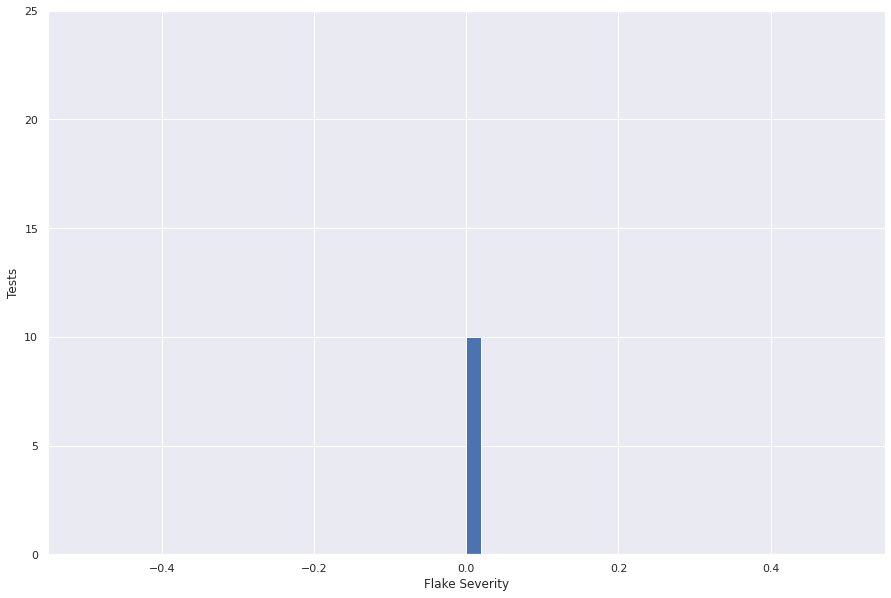

In [10]:
sns.set(rc={"figure.figsize": (15, 10)})
flake_severity.flake_severity.hist(bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0, 25))
plt.show()

### Save results to Ceph or locally
* Use the following helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not. 

In [11]:
timestamp = datetime.datetime.now()

if AUTOMATION:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(
        df,
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    save_to_disk(
        df,
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

In [12]:
## Sanity check to see if the dataset is the same
if AUTOMATION:
    sanity_check = cc.read_from_ceph(
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    sanity_check = read_from_disk(
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

sanity_check

,timestamp,tab,grid,test,test_duration,flake
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.283333,False
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.050000,False
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.983333,False
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,117.716667,False
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.633333,False
...,...,...,...,...,...,...
195,2021-03-12 16:31:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-api-machinery] CustomReso...,NaN,False
196,2021-03-11 17:51:37,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-api-machinery] CustomReso...,NaN,False
197,2021-03-11 11:53:33,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-api-machinery] CustomReso...,NaN,False
198,2021-03-11 02:04:17,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-api-machinery] CustomReso...,NaN,False


### Conclusion
- Report the status of the calculation that you aimed to complete in this notebook.
- Highlight any difficulties in the calculation of the metric.
- Optional: Add any side notes, future efforts

### _Example Conclusion_ 
_This notebook computed number of flakes and the flake severity metric. The dataframe saved on ceph can be used to generate aggregated views and visualizations._